In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib
import matplotlib.pyplot as plt
from keras.metrics import mean_absolute_error
from keras.metrics import mean_absolute_percentage_error
from keras.metrics import mean_squared_error


# Libraries for displying the data. 
from IPython.core.display import HTML 
from ipywidgets import interact
from IPython.display import display
import seaborn as sns
%matplotlib inline

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Dataset
downloaded = drive.CreateFile({'id':"12f9gd7u5hGDwWEZgOd-O9iMkM6lE9vF-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stock_prices_sample.csv')        # replace the file name with your file
#Dataset
downloaded = drive.CreateFile({'id':"1jJapq3dnv8iyMHtxJSp-hRJl8E1rCrUu"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
stock_prices = pd.read_csv('stock_prices_sample.csv')

In [0]:
stock_prices['DATE'] = pd.to_datetime(stock_prices["DATE"])
stock_prices['date'] = stock_prices['DATE']
stock_prices = stock_prices.sort_values(by="DATE")
stock_prices.set_index("DATE", inplace = True) 
stock_prices['Year']=stock_prices.index.year
stock_prices = stock_prices[stock_prices.Year != 2013]

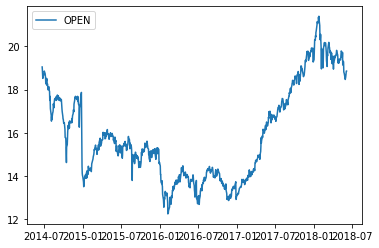

In [0]:
sns.lineplot(data=stock_prices['OPEN'], label="OPEN") 

In [0]:
def lag_features(df , N , col , col_index):
  "adds lag features of the given columnb for previous N days"
  series = df[col]
  for i in range(N):
    shifted_rows = np.zeros(len(df))
    shifted_rows[:] = np.nan
    array_index = i+1
    for j in range(len(df)-(i+1)):
      shifted_rows[array_index] = df.iloc[j,col_index]
      array_index = array_index + 1 
      df[col+'_lag_'+str(i+1)] = shifted_rows
  return df

In [0]:
stock_prices.columns

Index(['TICKER', 'FIGI', 'TYPE', 'FREQUENCY', 'OPEN', 'HIGH', 'LOW', 'CLOSE',
       'VOLUME', 'ADJ_OPEN', 'ADJ_HIGH', 'ADJ_LOW', 'ADJ_CLOSE', 'ADJ_VOLUME',
       'ADJ_FACTOR', 'EX_DIVIDEND', 'SPLIT_RATIO', 'date', 'Year'],
      dtype='object')

In [0]:
stock_prices = stock_prices[['OPEN', 'HIGH', 'LOW', 'CLOSE','VOLUME' , 'date' , 'Year']]

In [0]:
stock_prices_w_lag = lag_features(stock_prices,1,'OPEN',0)

In [0]:
stock_prices_w_lag

,OPEN,HIGH,LOW,CLOSE,VOLUME,date,Year,OPEN_lag_1
DATE,,,,,,,,
2014-06-23,19.05,19.0500,18.9500,18.95,34300.0,2014-06-23,2014,NaN
2014-06-24,18.91,18.9500,18.8300,18.83,35200.0,2014-06-24,2014,19.05
2014-06-25,18.66,18.7200,18.5900,18.60,171700.0,2014-06-25,2014,18.91
2014-06-26,18.52,18.5901,18.4200,18.53,60000.0,2014-06-26,2014,18.66
2014-06-27,18.63,18.6300,18.5100,18.61,28400.0,2014-06-27,2014,18.52
...,...,...,...,...,...,...,...,...
2018-05-30,18.47,18.6780,18.4700,18.65,22633.0,2018-05-30,2018,18.51
2018-05-31,18.52,18.5200,18.3012,18.49,22384.0,2018-05-31,2018,18.47
2018-06-01,18.58,18.7600,18.5800,18.74,17468.0,2018-06-01,2018,18.52


**Naive Forecast** 

In [0]:
#Naive forecast is OPEN_lag_1
print(mean_squared_error(np.array(stock_prices.iloc[1:, 0]) , np.array(stock_prices.iloc[1:,-1])))
print(mean_absolute_error(np.array(stock_prices.iloc[1:, 0]) , np.array(stock_prices.iloc[1:,-1])))
print(mean_absolute_percentage_error(np.array(stock_prices.iloc[1:, 0]) , np.array(stock_prices.iloc[1:,-1])))

tf.Tensor(0.04484693, shape=(), dtype=float32)
tf.Tensor(0.12981546, shape=(), dtype=float32)
tf.Tensor(0.8256181, shape=(), dtype=float32)


**Moving Average Forecast**

In [0]:
def moving_avg_std(df ,col ,N ,col_index):
  moving_mean = df[col].rolling(window = N, min_periods=1).mean() 
  moving_std = df[col].rolling(window = N, min_periods=1).std()   
  
  moving_mean = np.concatenate((np.array([np.nan]), np.array(moving_mean[:-1])))
  moving_std = np.concatenate((np.array([np.nan]), np.array(moving_std[:-1])))
    
  df[col + '_mean'] = moving_mean

In [0]:
stock_prices_w_lag = lag_features(stock_prices,7,'OPEN',0)

In [0]:
moving_avg_std(stock_prices_w_lag , 'OPEN' , 7 , 0)

In [0]:
stock_prices_w_lag

,OPEN,HIGH,LOW,CLOSE,VOLUME,date,Year,OPEN_lag_1,OPEN_lag_2,OPEN_lag_3,OPEN_lag_4,OPEN_lag_5,OPEN_lag_6,OPEN_lag_7,OPEN_mean
DATE,,,,,,,,,,,,,,,
2014-06-23,19.05,19.0500,18.9500,18.95,34300.0,2014-06-23,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-24,18.91,18.9500,18.8300,18.83,35200.0,2014-06-24,2014,19.05,NaN,NaN,NaN,NaN,NaN,NaN,19.050000
2014-06-25,18.66,18.7200,18.5900,18.60,171700.0,2014-06-25,2014,18.91,19.05,NaN,NaN,NaN,NaN,NaN,18.980000
2014-06-26,18.52,18.5901,18.4200,18.53,60000.0,2014-06-26,2014,18.66,18.91,19.05,NaN,NaN,NaN,NaN,18.873333
2014-06-27,18.63,18.6300,18.5100,18.61,28400.0,2014-06-27,2014,18.52,18.66,18.91,19.05,NaN,NaN,NaN,18.785000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-30,18.47,18.6780,18.4700,18.65,22633.0,2018-05-30,2018,18.51,18.76,18.78,18.83,19.26,19.31,19.14,18.941429
2018-05-31,18.52,18.5200,18.3012,18.49,22384.0,2018-05-31,2018,18.47,18.51,18.76,18.78,18.83,19.26,19.31,18.845714
2018-06-01,18.58,18.7600,18.5800,18.74,17468.0,2018-06-01,2018,18.52,18.47,18.51,18.76,18.78,18.83,19.26,18.732857


In [0]:
#Moving Average Forecast is OPEN_mean
print(mean_squared_error(np.array(stock_prices.iloc[1:, 0]) , np.array(stock_prices.iloc[1:,-1])))
print(mean_absolute_error(np.array(stock_prices.iloc[1:, 0]) , np.array(stock_prices.iloc[1:,-1])))
print(mean_absolute_percentage_error(np.array(stock_prices.iloc[1:, 0]) , np.array(stock_prices.iloc[1:,-1])))

tf.Tensor(0.119112104, shape=(), dtype=float32)
tf.Tensor(0.22926937, shape=(), dtype=float32)
tf.Tensor(1.4573811, shape=(), dtype=float32)
